
# Plate recognition
This code is a recognition of a Russian number plate. The main concept is:

1. Undistort the plate
2. Perform segmentation
3. Recognize symbols
4. Concatenate recognized symbols

### Preparations

In [218]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [219]:
# Import libraries
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
# set inline plots size
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)
import numpy as np
import cv2
import imutils
from imutils.contours import sort_contours
import pytesseract
from termcolor import colored

In [220]:
!wget "https://drive.google.com/uc?export=view&id=1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf" -O russian_plate_recog.jpg

img_gray = cv2.imread("russian_plate_recog.jpg", cv2.IMREAD_GRAYSCALE)

--2020-09-04 20:36:50--  https://drive.google.com/uc?export=view&id=1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf
Resolving drive.google.com (drive.google.com)... 108.177.97.113, 108.177.97.101, 108.177.97.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.97.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tinpp36e8qv39ciko4evrpsat20u0271/1599251775000/17396682441590382856/*/1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf?e=view [following]
--2020-09-04 20:36:50--  https://doc-04-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tinpp36e8qv39ciko4evrpsat20u0271/1599251775000/17396682441590382856/*/1vF8JiWOEkNd5NxtvQ1wfr8D-U3YGH3kf?e=view
Resolving doc-04-7s-docs.googleusercontent.com (doc-04-7s-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to doc-04-7s-docs.googleusercontent.com (doc-04-7s-docs.go

In [221]:
def order_points(pts):
    # place the points in order: top-left, top-right, bottom-right, bottom-left
    # just in case)

    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [222]:
plate_points_1 = np.array([[1028, 874], [1184, 890], [1184, 924], [1027, 906]], np.int32)
plate_points_2 = np.array([[293, 714], [422, 719], [421, 749], [291, 743]], np.int32)

points = []
points.append(order_points(plate_points_1))
points.append(order_points(plate_points_2))

## 1. Draw borders around the number plate

In [223]:
def draw_borders(img, points, size=(16,16)): 
  #draw a region on a copied image
  for plate_points in points:
    pts = np.array(plate_points, np.int32)
    cv2.polylines(img,[pts],True,(0,255,0), 3)
  
  plt.figure(figsize=size)
  plt.axis(False)
  plt.imshow(img, cmap='gray')

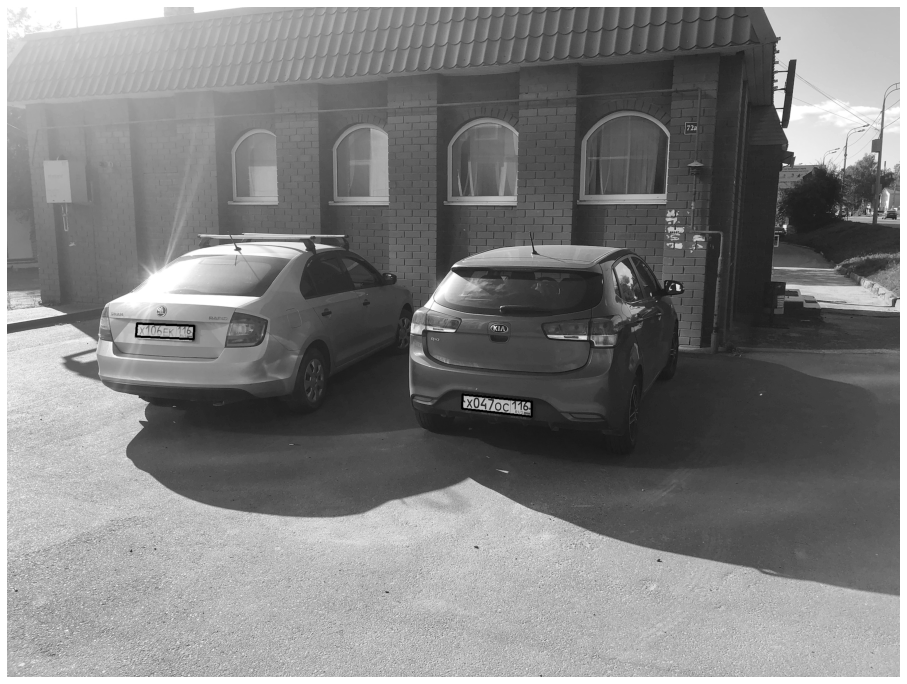

In [224]:
img = img_gray.copy()

draw_borders(img, points)

## 2. Undistort the plate

In [225]:
def undistort_plates(img, points, show=True, size=(16,16)):
  #for each plate in a set of points
  plates = [] 
  for plate_points in points:
    (tl, tr, br, bl) = plate_points
    #find width and height

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    #identify maximum width and height - they will be final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    #construct destination points
    dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype = "float32")

    #calculate perspective matrix and warp the perspective accordingly
    M = cv2.getPerspectiveTransform(plate_points, dst)
    warp = cv2.warpPerspective(img2, M, (maxWidth, maxHeight))
    plates.append(warp)

    #show the wrapped and cropped images
    if show:
      plt.figure(figsize=size)
      plt.axis(False)
      plt.imshow(warp, cmap='gray')

  return plates

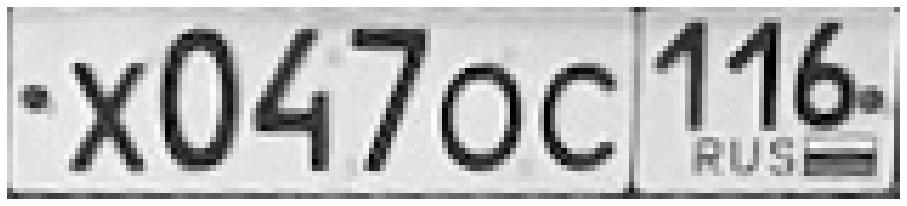

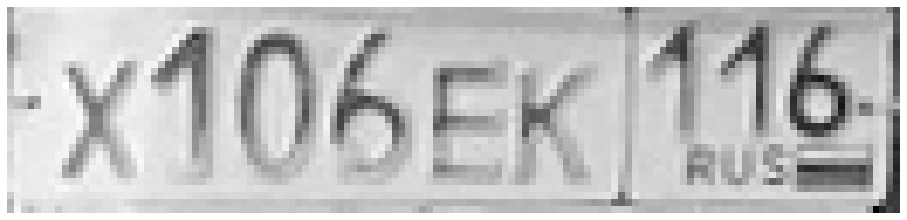

In [226]:
img2 = img_gray.copy()

plates = undistort_plates(img2, points)

## 3. Segmentation

In [267]:
def segmentation(img, size=(16,16)):
  #blur image
  blurred_img = cv2.GaussianBlur(img,(3,3),0)
  
  #apply thresholding
  tresholded_img = cv2.threshold(blurred_img, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  #apply dilation 
  kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
  final_img = cv2.morphologyEx(tresholded_img, cv2.MORPH_DILATE, kernel2)
 
  return final_img
  
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

def get_segmented_imgs(original_img, show=True, size=(16,16)):
    segmented_img = segmentation(original_img)
    contours, _  = cv2.findContours(segmented_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmented_imgs = []

    for c in sort_contours(contours):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        #check if a contour is valid
        if 1 <= ratio <= 3.5: 
            if h / original_img.shape[0] >= 0.4: 
                # draw a bounding box
                if ratio < 1.4: w = round(h/1.4)
                cv2.rectangle(original_img, (x, y), (x + w, y + h), (0, 255,0), 1)

                # add the segmented image to an array
                new_img = segmented_img[y:y+h,x:x+w]
                new_img = cv2.bitwise_not(new_img)
                segmented_imgs.append(new_img)
                 
    #show the image with bounding boxes
    if show:
      plt.figure(figsize=size)
      plt.axis(False)
      plt.imshow(original_img, cmap='gray') 
    
    return segmented_imgs 

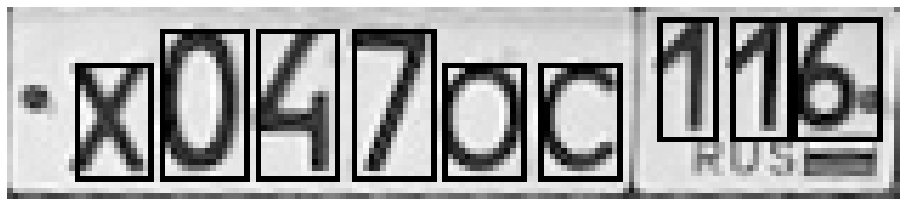

In [268]:
plate_image = plates[0].copy()
    
segmented_imgs = get_segmented_imgs(plate_image.copy())

## 4. Recognition

Here the PyTesseract library is used for the letters recognition.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


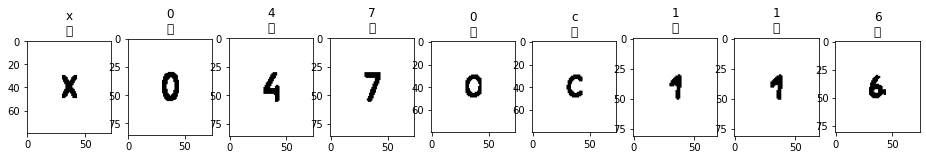

In [269]:
#prepare the figure for subplots
fig = plt.figure(figsize=(16,16))
grid = gridspec.GridSpec(ncols=len(segmented_imgs),nrows=1,figure=fig)

for i in range(len(segmented_imgs)): 
  img = segmented_imgs[i].copy()
  #add padding for better recognition quality
  img = cv2.copyMakeBorder(img, 30, 30, 30, 30, cv2.BORDER_CONSTANT, value=[255, 255, 255])
  fig.add_subplot(grid[i])
  char = pytesseract.image_to_string(img, lang='eng', config='--psm 10')
  plt.title(char)
  plt.imshow(img,cmap="gray")

## 5. Concatenation
Just put it all together 

In [270]:
def recognition(segmented_imgs):
  # go through all segmented images of numbers/letters, 
  # add paddings and recognise with the help of pytesseract
  answer = ''

  for i in range(len(segmented_imgs)): 
    img = segmented_imgs[i].copy()
    img = cv2.copyMakeBorder(img, 30, 30, 30, 30, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    char = pytesseract.image_to_string(img, lang='eng', config='--psm 10')
    answer += char[:1]
    
  return answer

In [271]:
#combine all from the beginning:
img = img_gray.copy()
plates = undistort_plates(img, points, show=False)
plate_image = plates[0].copy()
segmented_imgs = get_segmented_imgs(plate_image.copy(), show=False)
answer = recognition(segmented_imgs)
print(colored(answer,  attrs=['bold']))

x0470c116


¥4a&6


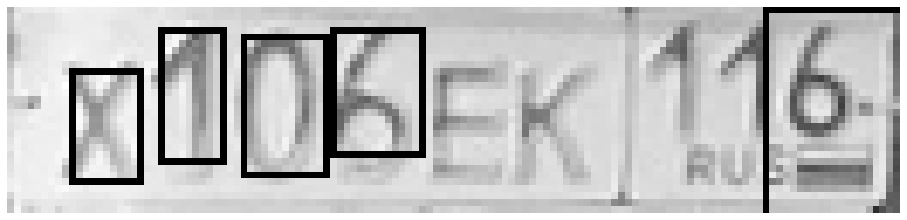

In [272]:
img = img_gray.copy()
plates = undistort_plates(img, points, False)
plate_image = plates[1].copy()
segmented_imgs = get_segmented_imgs(plate_image.copy())
answer = recognition(segmented_imgs)
print(colored(answer,  attrs=['bold']))